In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import pickle
import keras
from keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.losses import binary_crossentropy
# from IPython import display
# import glob
# import imageio
# import PIL
# import os
# os.environ["KERAS_BACKEND"] = "tensorflow"



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

all_labels_test = np.concatenate([y_train, y_test])

all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size=100)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


In [4]:
batch_size = 100
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 100

generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes

print(generator_in_channels, discriminator_in_channels)

110 11


In [5]:
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((28, 28, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)



In [6]:
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        layers.Dense(7 * 7 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [7]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.real_accuracy_tracker = keras.metrics.Mean(name="real_image_accuracy")
        self.fake_accuracy_tracker = keras.metrics.Mean(name="fake_image_accuracy")


    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker, self.real_accuracy_tracker, self.fake_accuracy_tracker]


    def compile(self, d_optimizer, g_optimizer, loss_fn, metrics):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.custom_metrics  = metrics


    def train_step(self, data):
        real_images, one_hot_labels = data
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        generated_images = self.generator(random_vector_labels)

        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))



        f_predictions = self.discriminator(fake_image_and_labels)
        r_predictions = self.discriminator(real_image_and_labels)

        f_acc = tf.reduce_mean(f_predictions)
        r_acc =  tf.reduce_mean(r_predictions)

        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.fake_accuracy_tracker.update_state(f_acc)
        self.real_accuracy_tracker.update_state(r_acc)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "r_acc": self.real_accuracy_tracker.result(),
            "f_acc": self.fake_accuracy_tracker.result()
        }

In [8]:
class Visualizer(keras.callbacks.Callback):
    def __init__(self, generator_test, discriminator_test, real_images, real_labels):
        self.generator_test = generator_test
        self.discriminator_test = discriminator_test
        self.latent_dim = 100
        self.real_images = real_images
        self.real_labels = real_labels

    def on_train_end(self, logs=None):
      self.generator_test.save('/content/drive/MyDrive/ML backend/PortfolioProjects/genAI/VanillaConditionalGANS/p1_gen.h5')
      self.discriminator_test.save('/content/drive/MyDrive/ML backend/PortfolioProjects/genAI/VanillaConditionalGANS/p1_dis.h5')


    def on_epoch_end(self, epoch, logs=None):
      one_hot_labels = tf.one_hot(tf.constant([0,1,2,3,4,5,6,7,8,9]), 10)
      random_latent_vectors = tf.random.normal(shape=(10, self.latent_dim))
      random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)
      generated_images = self.generator_test(random_vector_labels)

      real_images_and_labels, real_images_plotting = self.get_real_image_and_labels()
      fake_images_and_labels = self.get_fake_images_and_labels(generated_images, one_hot_labels)

      dicriminator_output_real_images = self.discriminator_test(real_images_and_labels)
      dicriminator_output_fake_images = self.discriminator_test(fake_images_and_labels)

      self.plot_images_with_disoutput(real_images_plotting, dicriminator_output_real_images, 'Real Images')
      self.plot_images_with_disoutput(generated_images, dicriminator_output_fake_images, 'Fake Images')


    def get_fake_images_and_labels(self, generated_images, one_hot_labels):
      image_one_hot_labels_test =  tf.repeat(one_hot_labels, repeats=[28 * 28])
      image_one_hot_labels_test = tf.reshape(image_one_hot_labels_test, (-1, 28, 28, 10))
      fake_images_and_labels = tf.concat([generated_images, image_one_hot_labels_test], -1)
      return fake_images_and_labels


    def get_real_image_and_labels(self,):
      selected_images = []
      selected_labels = []
      real_images_plotting = []

      for class_label in range(10):
        class_indices = np.where(self.real_labels == class_label)[0]
        selected_indices = np.random.choice(class_indices, size=1, replace=False)

        onehot_label = tf.one_hot(class_label,10)
        real_image = self.real_images[selected_indices]
        selected_images.append(real_image)
        real_images_plotting.append(real_image.reshape(28,28))
        selected_labels.append(onehot_label)

      selected_images_np = np.array(selected_images).reshape(10,28,28,1)
      image_one_hot_labels_test =  tf.repeat(np.array(selected_labels), repeats=[28 * 28])
      image_one_hot_labels_test = tf.reshape(image_one_hot_labels_test, (-1, 28, 28, 10))
      real_image_and_labels = tf.concat([selected_images_np, image_one_hot_labels_test], -1)

      return real_image_and_labels, real_images_plotting

    def plot_images_with_disoutput(self, images_for_plotting, dicriminator_output, title):
        fig, axs = plt.subplots(1, 10, figsize=(18, 2))
        i = 0

        for image, label in zip(images_for_plotting, dicriminator_output):
          axs[i].imshow(image, cmap='gray')
          axs[i].axis('off')
          axs[i].set_title(label.numpy())
          i += 1
        fig.suptitle(title)
        plt.show()

In [9]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)

cond_gan.generator.summary()
cond_gan.discriminator.summary()

cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0004),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=keras.metrics.BinaryAccuracy()
)

history = cond_gan.fit(dataset, epochs=100, callbacks=[Visualizer(cond_gan.generator, cond_gan.discriminator, all_digits, all_labels_test)])

Output hidden; open in https://colab.research.google.com to view.

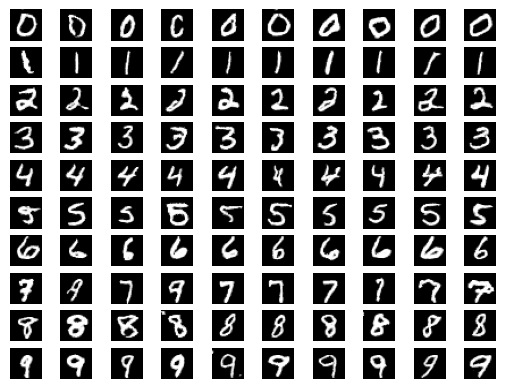

In [10]:
for i in range(10):
    one_hot_labels = tf.one_hot(tf.constant([i,i,i,i,i,i,i,i,i,i]), 10)
    random_latent_vectors = tf.random.normal(shape=(10, 100))
    generated_images = cond_gan.generator(tf.concat([random_latent_vectors, one_hot_labels], axis=-1))

    for j in range(10):
        plt_no = (i*10) + (j+1)
        plt.subplot(10, 10, plt_no)
        plt.imshow(generated_images[j,:,:,0], cmap='gray')
        plt.axis('off')
plt.show()

In [11]:
testing_gen = load_model('/content/drive/MyDrive/ML backend/PortfolioProjects/genAI/VanillaConditionalGANS/p1_gen.h5')

Please Enter a Digit : 8


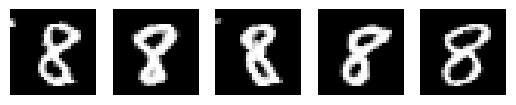

In [14]:
user_input = int(input('Please Enter a Digit : '))
one_hot_labels = tf.one_hot(tf.constant([user_input,user_input,user_input,user_input,user_input]), 10)
random_latent_vectors = tf.random.normal(shape=(5, 100))

generated_images = testing_gen(tf.concat([random_latent_vectors, one_hot_labels], axis=-1))

for j in range(5):
    plt.subplot(1, 5, j+1)
    plt.imshow(generated_images[j,:,:,0], cmap='gray')
    plt.axis('off')
plt.show()